In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [3]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [4]:
def softmax(vals, tau=1.12):
    return np.exp(vals/tau) / np.sum(np.exp(vals/tau))

In [5]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

In [6]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms #N : batch size, D_in : input layer, H : hidden layer size, D_out : output layer

model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
    nn.ReLU()
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [7]:
env = ContextBandit(arms)
epochs = 5000
rewards = []

state = torch.Tensor(one_hot(arms, env.get_state()))

for t in range(epochs):
    preds = model(state)
    probs = softmax(preds.data.numpy(), tau=2.0)
    probs /= probs.sum()
    
    choice = np.random.choice(arms, p=probs)
    cur_reward = env.choose_arm(choice)
    
    one_hot_reward = preds.data.numpy().copy()
    one_hot_reward[choice] = cur_reward
    
    reward = torch.Tensor(one_hot_reward)
    rewards.append(cur_reward)
    
    loss = loss_fn(preds, reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    state = torch.Tensor(one_hot(arms, env.get_state()))


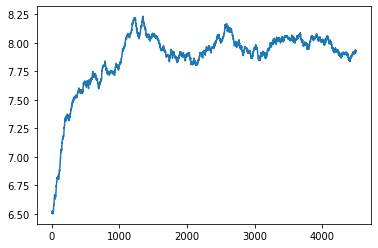

In [8]:
plt.plot(running_mean(np.array(rewards),N=500))